In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 48,         # Label size for y ticks
    'xtick.labelsize': 48,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [123]:
df = pd.read_csv('../Re_normalized.csv')
# Remove any sequence that doesn't have a standard amino acid
standard_aa = set('ACDEFGHIKLMNPQRSTVWY')  # Set of standard amino acid characters
# Use DataFrame.apply to check each sequence, keeping only those that are subsets of standard_aa
df = df[df['ADseq'].apply(lambda x: set(x.upper()).issubset(standard_aa))]

# Update 'status' based on the criteria provided
df['status'] = df.apply(
    lambda row: 'deactivating' if row['-log10_p-values'] > 1.30102999566 and row['log2_FC'] < -1 else 
                ('activating' if row['-log10_p-values'] > 1.30102999566 and row['log2_FC'] > 1 else 
                 'neutral'),
    axis=1
)

In [124]:
import pandas as pd
from sparrow import Protein
# from sparrow import AnalyticalFRC

# Initialize an empty DataFrame for storing results
results_df = pd.DataFrame()

# Iterate over each sequence in the 'ADseq' column of df
for idx, IDR_seq in df['ADseq'].items():  # Use .items() for Series
    # Initialize a dictionary to hold the data for this sequence
    IDR_data = {'ADseq': IDR_seq}  # Add the sequence itself to IDR_data
    
    # Predict properties using Sparrow
    P = Protein(IDR_seq)
    IDR_data['Rg'] = P.predictor.radius_of_gyration()
    IDR_data['Re'] = P.predictor.end_to_end_distance(use_scaled=True)
    IDR_data['Asphericity'] = P.predictor.asphericity()
    
    # Get other properties of IDR
    IDR_data['NCPR'] = P.NCPR
    IDR_data['FCR'] = P.FCR
    IDR_data['kappa'] = P.kappa
    IDR_data['hy_KD'] = P.hydrophobicity
    IDR_data['hy_clust'] = P.compute_kappa_x(["I","L","V","A","M"])
    IDR_data['aro_clust'] = P.compute_kappa_x(["F","Y","W","L"])
    IDR_data['AEM clustering'] = P.compute_kappa_x(["F","Y","L",'W'],['D','E'])
    IDR_data['SCD'] = P.SCD
    IDR_data['SHD'] = P.SHD
    IDR_data['NCPR'] = P.complexity
    IDR_data['Aromatic Fraction'] = P.fraction_aromatic
    IDR_data['Negative Charge Fraction']= P.fraction_negative
    
# Calculate the fraction of specific amino acids
    specific_amino_acids = ['D', 'E', 'L', 'W', 'T', 'F', 'Y']

    IDR_data['AEM Fraction'] = P.compute_residue_fractions(specific_amino_acids)

    # Append the data for this sequence to the results DataFrame
    # Convert IDR_data dictionary to a DataFrame with a single row
    single_idr_df = pd.DataFrame([IDR_data])
    # Append this row to the results_df
    results_df = pd.concat([results_df, single_idr_df], ignore_index=True)

# At this point, results_df contains all the calculated data for each sequence in 'ADseq', including the sequence itself
results_df
# Assuming 'df' and 'results_df' are your DataFrames
# And 'ADseq' is the column you want to match on
combined_df = pd.merge(df, results_df, on='ADseq', how='left')
combined_df.rename(columns={'Re_normalized': r'$R_{e}$ Normalized'}, inplace=True)
print(combined_df.columns)

Index(['Index', 'ADseq', 'Variant_Name', 'SystematicName',
       'Activity_Mean_MSS18', 'Activity_std_MSS18',
       'Biological_Replicate_1_Activity', 'Biological_Replicate_2_Activity',
       'Biological_Replicate_3_Activity', 'Biological_Replicate_4_Activity',
       '8_Bin_sort', 'WT', 'HandDesigned', 'PerturbCharge', 'PerturbAromatics',
       'CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1',
       'CorrectedPvalues_FDR_5percent', 'SigDiffFromWT', 'ree (nm)',
       'activity', '-log10_p-values', 'normalized_activity', 'log2_FC',
       'color', '$R_{e}$ Normalized', 'status', 'Rg', 'Re', 'Asphericity',
       'NCPR', 'FCR', 'kappa', 'hy_KD', 'hy_clust', 'aro_clust',
       'AEM clustering', 'SCD', 'SHD', 'Aromatic Fraction',
       'Negative Charge Fraction', 'AEM Fraction'],
      dtype='object')


In [125]:
# filtered_df = combined_df[combined_df['Hif1alpha']]
# print(filtered_df.columns)
combined_df

,Index,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,...,kappa,hy_KD,hy_clust,aro_clust,AEM clustering,SCD,SHD,Aromatic Fraction,Negative Charge Fraction,AEM Fraction
0,0.0,ALLGQSMAASGLPQLTSYACAVNAPIQGSANLLQGAALLAALAQVN,EDKR>A,"R781A,D788A,E789A,D799A,E801A,R810A,E816A,E817...",2123.985450,988.629563,2589.385071,1699.308038,2911.429186,1610.987890,...,-1.000000,5.263043,0.112292,0.352366,-1.000000,0.000000,3.611160,0.021739,0.000000,0.239130
1,1.0,ALLGQSMDESGLPQLTSYDCEVNAPIQGSANLLQGEELLAALDQVN,RK>A,"R781A,R810A,R820A",3614.586555,1507.208525,5566.727883,1887.337054,3091.531077,3060.888090,...,-1.000000,4.456522,0.093488,0.352366,0.146552,1.712989,3.380963,0.021739,0.152174,0.391304
2,2.0,DDDIDLPMDPRDLDDLMDFGDDGEGAEPDAGGDFEDLDFDMELDDE,STQN>D,"S719D,N720D,T721D,S727D,T730D,S733D,Q736D,N739...",2621.306903,461.134697,2936.204576,2416.880868,2010.962589,2382.925480,...,0.192044,3.400000,0.167247,0.356188,0.097236,19.507723,3.010786,0.065217,0.500000,0.673913
3,3.0,DDDIDLPMDPRDLDDLMDFGDDGEGAEPSAGGQFESLTFDMELTSE,STQN>Dmut0to23,"S719D,N720D,T721D,S727D,T730D,S733D,Q736D,N739...",2734.312216,355.925699,2708.731489,2594.086646,1956.135345,2663.639252,...,0.197466,3.697826,0.167247,0.356188,0.105700,10.028349,3.148256,0.065217,0.369565,0.586957
4,4.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGDDEFDFMDD,STQN>D,"T220D,S230D,Q250D,N251D,T257D",4934.729353,580.260971,4662.342770,4519.208720,3848.559508,5150.358116,...,0.256003,4.271795,0.129051,0.082757,0.037519,8.699679,3.114148,0.102564,0.410256,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,519.0,TEFIEEEVLMSLVIEMGLERIKELPELWLGQNEFEFMTE,ED>E,"D221E,D224E,D238E,D254E,D258E",3208.629716,305.383594,2986.304531,2673.700940,2995.332506,3234.454492,...,0.223453,4.484615,0.129051,0.082757,0.056260,3.498430,3.254511,0.102564,0.282051,0.589744
472,520.0,TKFIKKKVLMSLVIKMGLKRIKELPELWLGQNEFDFMTD,ED>Kmut0to20,"D221K,D224K,E225K,E226K,E234K,D238K",2546.054013,726.371036,3289.399753,2127.052673,2127.811956,2001.830976,...,0.400091,4.423077,0.129051,0.082757,0.095530,-1.614512,3.276317,0.102564,0.128205,0.435897
473,521.0,TKFIKKKVLMSLVIKMGLKRIKKLPKLWLGQNKFKFMTK,ED>K,"D221K,D224K,E225K,E226K,E234K,D238K,E242K,E245...",2371.893236,461.988449,2707.282443,2314.819359,1789.390928,2338.011421,...,-1.000000,4.371795,0.129051,0.082757,-1.000000,6.965567,3.322781,0.102564,0.000000,0.307692
474,522.0,TRFIRRRVLMSLVIRMGLRRIKELPELWLGQNEFDFMTD,ED>Rmut0to20,"D221R,D224R,E225R,E226R,E234R,D238R",2327.564901,500.105608,2708.238559,2150.713640,1751.071974,2022.488505,...,0.400091,4.330769,0.129051,0.082757,0.095530,-1.614512,2.928324,0.102564,0.128205,0.435897


In [135]:
print(combined_df.columns)
#filtered_df = combined_df[combined_df['Hif1alpha']]
# Assuming 'df' is your DataFrame

combined_df = combined_df[combined_df['AEM clustering'] > -0.5]
combined_df = combined_df[combined_df['CITED2'] == True]

filtered_df=combined_df
filtered_df

Index(['Index', 'ADseq', 'Variant_Name', 'SystematicName',
       'Activity_Mean_MSS18', 'Activity_std_MSS18',
       'Biological_Replicate_1_Activity', 'Biological_Replicate_2_Activity',
       'Biological_Replicate_3_Activity', 'Biological_Replicate_4_Activity',
       '8_Bin_sort', 'WT', 'HandDesigned', 'PerturbCharge', 'PerturbAromatics',
       'CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1',
       'CorrectedPvalues_FDR_5percent', 'SigDiffFromWT', 'ree (nm)',
       'activity', '-log10_p-values', 'normalized_activity', 'log2_FC',
       'color', '$R_{e}$ Normalized', 'status', 'Rg', 'Re', 'Asphericity',
       'NCPR', 'FCR', 'kappa', 'hy_KD', 'hy_clust', 'aro_clust',
       'AEM clustering', 'SCD', 'SHD', 'Aromatic Fraction',
       'Negative Charge Fraction', 'AEM Fraction'],
      dtype='object')


,Index,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,...,kappa,hy_KD,hy_clust,aro_clust,AEM clustering,SCD,SHD,Aromatic Fraction,Negative Charge Fraction,AEM Fraction
4,4.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGDDEFDFMDD,STQN>D,"T220D,S230D,Q250D,N251D,T257D",4934.729353,580.260971,4662.342770,4519.208720,3848.559508,5150.358116,...,0.256003,4.271795,0.129051,0.082757,0.037519,8.699679,3.114148,0.102564,0.410256,0.666667
5,5.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGQNEFDFMDD,ST>D,"T220D,S230D,T257D",4929.553911,688.559113,4259.084605,4276.234562,4246.226448,5031.713249,...,0.231149,4.271795,0.129051,0.082757,0.054274,6.398789,3.136979,0.102564,0.358974,0.615385
6,6.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGQNEFDFMTD,ST>Dmut0to20,"T220D,S230D",4920.596376,521.396849,4672.160467,5012.269467,3673.177490,5089.802833,...,0.219307,4.343590,0.129051,0.082757,0.048972,5.207369,3.161443,0.102564,0.333333,0.615385
10,12.0,EDFIDEEVLMELVIEMGLDRIKELPELWLGEEEFDFMED,STQN>E,"T220E,S230E,Q250E,N251E,T257E",5522.323440,1172.910957,5336.792073,4387.979038,4822.957103,4934.043489,...,0.256003,4.271795,0.129051,0.082757,0.037519,8.699679,3.156971,0.102564,0.410256,0.666667
11,13.0,EDFIDEEVLMELVIEMGLDRIKELPELWLGQNEFDFMED,ST>E,"T220E,S230E,T257E",4987.516255,988.613564,5202.254986,4066.235341,3440.023242,5346.668006,...,0.231149,4.271795,0.129051,0.082757,0.054274,6.398789,3.160419,0.102564,0.358974,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,517.0,TDYIDEEVLMSLVIEMGLDRIKELPELYLGQNEYDYMTD,WF>Y,"F222Y,W247Y,F253Y,F255Y",3726.761825,629.997494,3715.148378,3530.774170,3060.171764,3106.079531,...,0.223453,4.158974,0.129051,0.082757,0.056260,3.498430,3.161295,0.102564,0.282051,0.589744
470,518.0,TEFIEEEVLMSLVIEMGLERIKELPELWLGQNEFDFMTD,ED>Emut0to20,"D221E,D224E,D238E",3144.825771,686.883901,3680.793448,2728.489682,2951.250927,2479.166620,...,0.223453,4.484615,0.129051,0.082757,0.056260,3.498430,3.239080,0.102564,0.282051,0.589744
471,519.0,TEFIEEEVLMSLVIEMGLERIKELPELWLGQNEFEFMTE,ED>E,"D221E,D224E,D238E,D254E,D258E",3208.629716,305.383594,2986.304531,2673.700940,2995.332506,3234.454492,...,0.223453,4.484615,0.129051,0.082757,0.056260,3.498430,3.254511,0.102564,0.282051,0.589744
472,520.0,TKFIKKKVLMSLVIKMGLKRIKELPELWLGQNEFDFMTD,ED>Kmut0to20,"D221K,D224K,E225K,E226K,E234K,D238K",2546.054013,726.371036,3289.399753,2127.052673,2127.811956,2001.830976,...,0.400091,4.423077,0.129051,0.082757,0.095530,-1.614512,3.276317,0.102564,0.128205,0.435897


In [136]:
import pandas as pd
import scipy.stats as stats

# Load your DataFrame here if not already loaded
# filtered_df = pd.read_csv('your_data.csv')

# List of columns to perform t-tests on
features = ['$R_{e}$ Normalized', 'Rg', 'Re', 'Asphericity', 'NCPR', 'FCR', 'kappa',
            'hy_KD', 'hy_clust', 'aro_clust', 'AEM clustering', 'SCD', 'SHD','Aromatic Fraction',
       'Negative Charge Fraction', 'AEM Fraction']

# Initialize a dictionary to hold the t-test results
t_test_results = {}

def is_significant(p_val):
    if p_val < 0.0001:
        return '***'  # Triple asterisk for p < 0.0001
    elif p_val < 0.001:
        return '**'   # Double asterisk for p < 0.001
    elif p_val < 0.01:
        return '*'    # Single asterisk for p < 0.01
    else:
        return 'NS'  # No annotation for p >= 0.01

for feature in features:
    # Split the data into two groups based on the 'status' column
    group1 = filtered_df[filtered_df['status'] == 'neutral'][feature]
    group2 = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Using Welch's t-test by default
    
    # Store the results including the asterisk annotation
    t_test_results[feature] = {'t-statistic': t_stat, 'p-value': p_value, 'asterisk': is_significant(p_value)}

# Convert results dictionary to DataFrame for nicer display
t_test_results_df = pd.DataFrame(t_test_results).transpose()

print(t_test_results_df)


                         t-statistic   p-value asterisk
$R_{e}$ Normalized          4.732889  0.000052      ***
Rg                          5.418443  0.000007      ***
Re                          4.732889  0.000052      ***
Asphericity                 3.996531  0.000419       **
NCPR                         0.63803  0.527644       NS
FCR                         1.239903  0.224089       NS
kappa                      -2.632514  0.009785        *
hy_KD                       0.679832  0.502122       NS
hy_clust                    -2.78411   0.00953        *
aro_clust                  -0.037564  0.970206       NS
AEM clustering             -2.628579  0.013336       NS
SCD                          5.73066  0.000001      ***
SHD                         0.082813  0.934556       NS
Aromatic Fraction          -2.653136  0.012574       NS
Negative Charge Fraction    4.476693  0.000091      ***
AEM Fraction                2.732705  0.010149       NS


In [137]:
import pandas as pd
from scipy.stats import mannwhitneyu

# List of columns to perform t-tests on
features = ['$R_{e}$ Normalized', 'Rg', 'Re', 'Asphericity', 'NCPR', 'FCR', 'kappa',
            'hy_KD', 'hy_clust', 'aro_clust', 'AEM clustering', 'SCD', 'SHD','Aromatic Fraction',
       'Negative Charge Fraction', 'AEM Fraction']

# Initialize a dictionary to hold the Mann-Whitney U test results
mann_whitney_results = {}

def is_significant(p_val):
    if p_val < 0.0001:
        return '***'  # Triple asterisk for p < 0.0001
    elif p_val < 0.001:
        return '**'   # Double asterisk for p < 0.001
    elif p_val < 0.01:
        return '*'    # Single asterisk for p < 0.01
    else:
        return 'NS'  # No annotation for p >= 0.01

for feature in features:
    # Split the data into two groups based on the 'status' column
    group1 = filtered_df[filtered_df['status'] == 'neutral'][feature]
    group2 = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    
    # Perform Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Store the results including the asterisk annotation
    mann_whitney_results[feature] = {
        'U-statistic': u_stat,
        'p-value (scientific)': f"{p_value:.2e}",
        'asterisk': is_significant(p_value)
    }

# Convert results dictionary to DataFrame for nicer display
mann_whitney_results_df = pd.DataFrame(mann_whitney_results).transpose()

print(mann_whitney_results_df)


                         U-statistic p-value (scientific) asterisk
$R_{e}$ Normalized            1865.0             1.20e-08      ***
Rg                            1867.0             1.11e-08      ***
Re                            1865.0             1.20e-08      ***
Asphericity                   1726.0             2.71e-06      ***
NCPR                          1079.0             9.97e-01       NS
FCR                           1269.5             1.20e-01       NS
kappa                          903.5             1.73e-01       NS
hy_KD                         1213.0             3.30e-01       NS
hy_clust                       675.0             1.30e-03        *
aro_clust                      968.5             3.46e-01       NS
AEM clustering                 645.5             1.18e-03        *
SCD                           1791.5             2.36e-08      ***
SHD                           1041.0             7.91e-01       NS
Aromatic Fraction              835.5             4.76e-02     

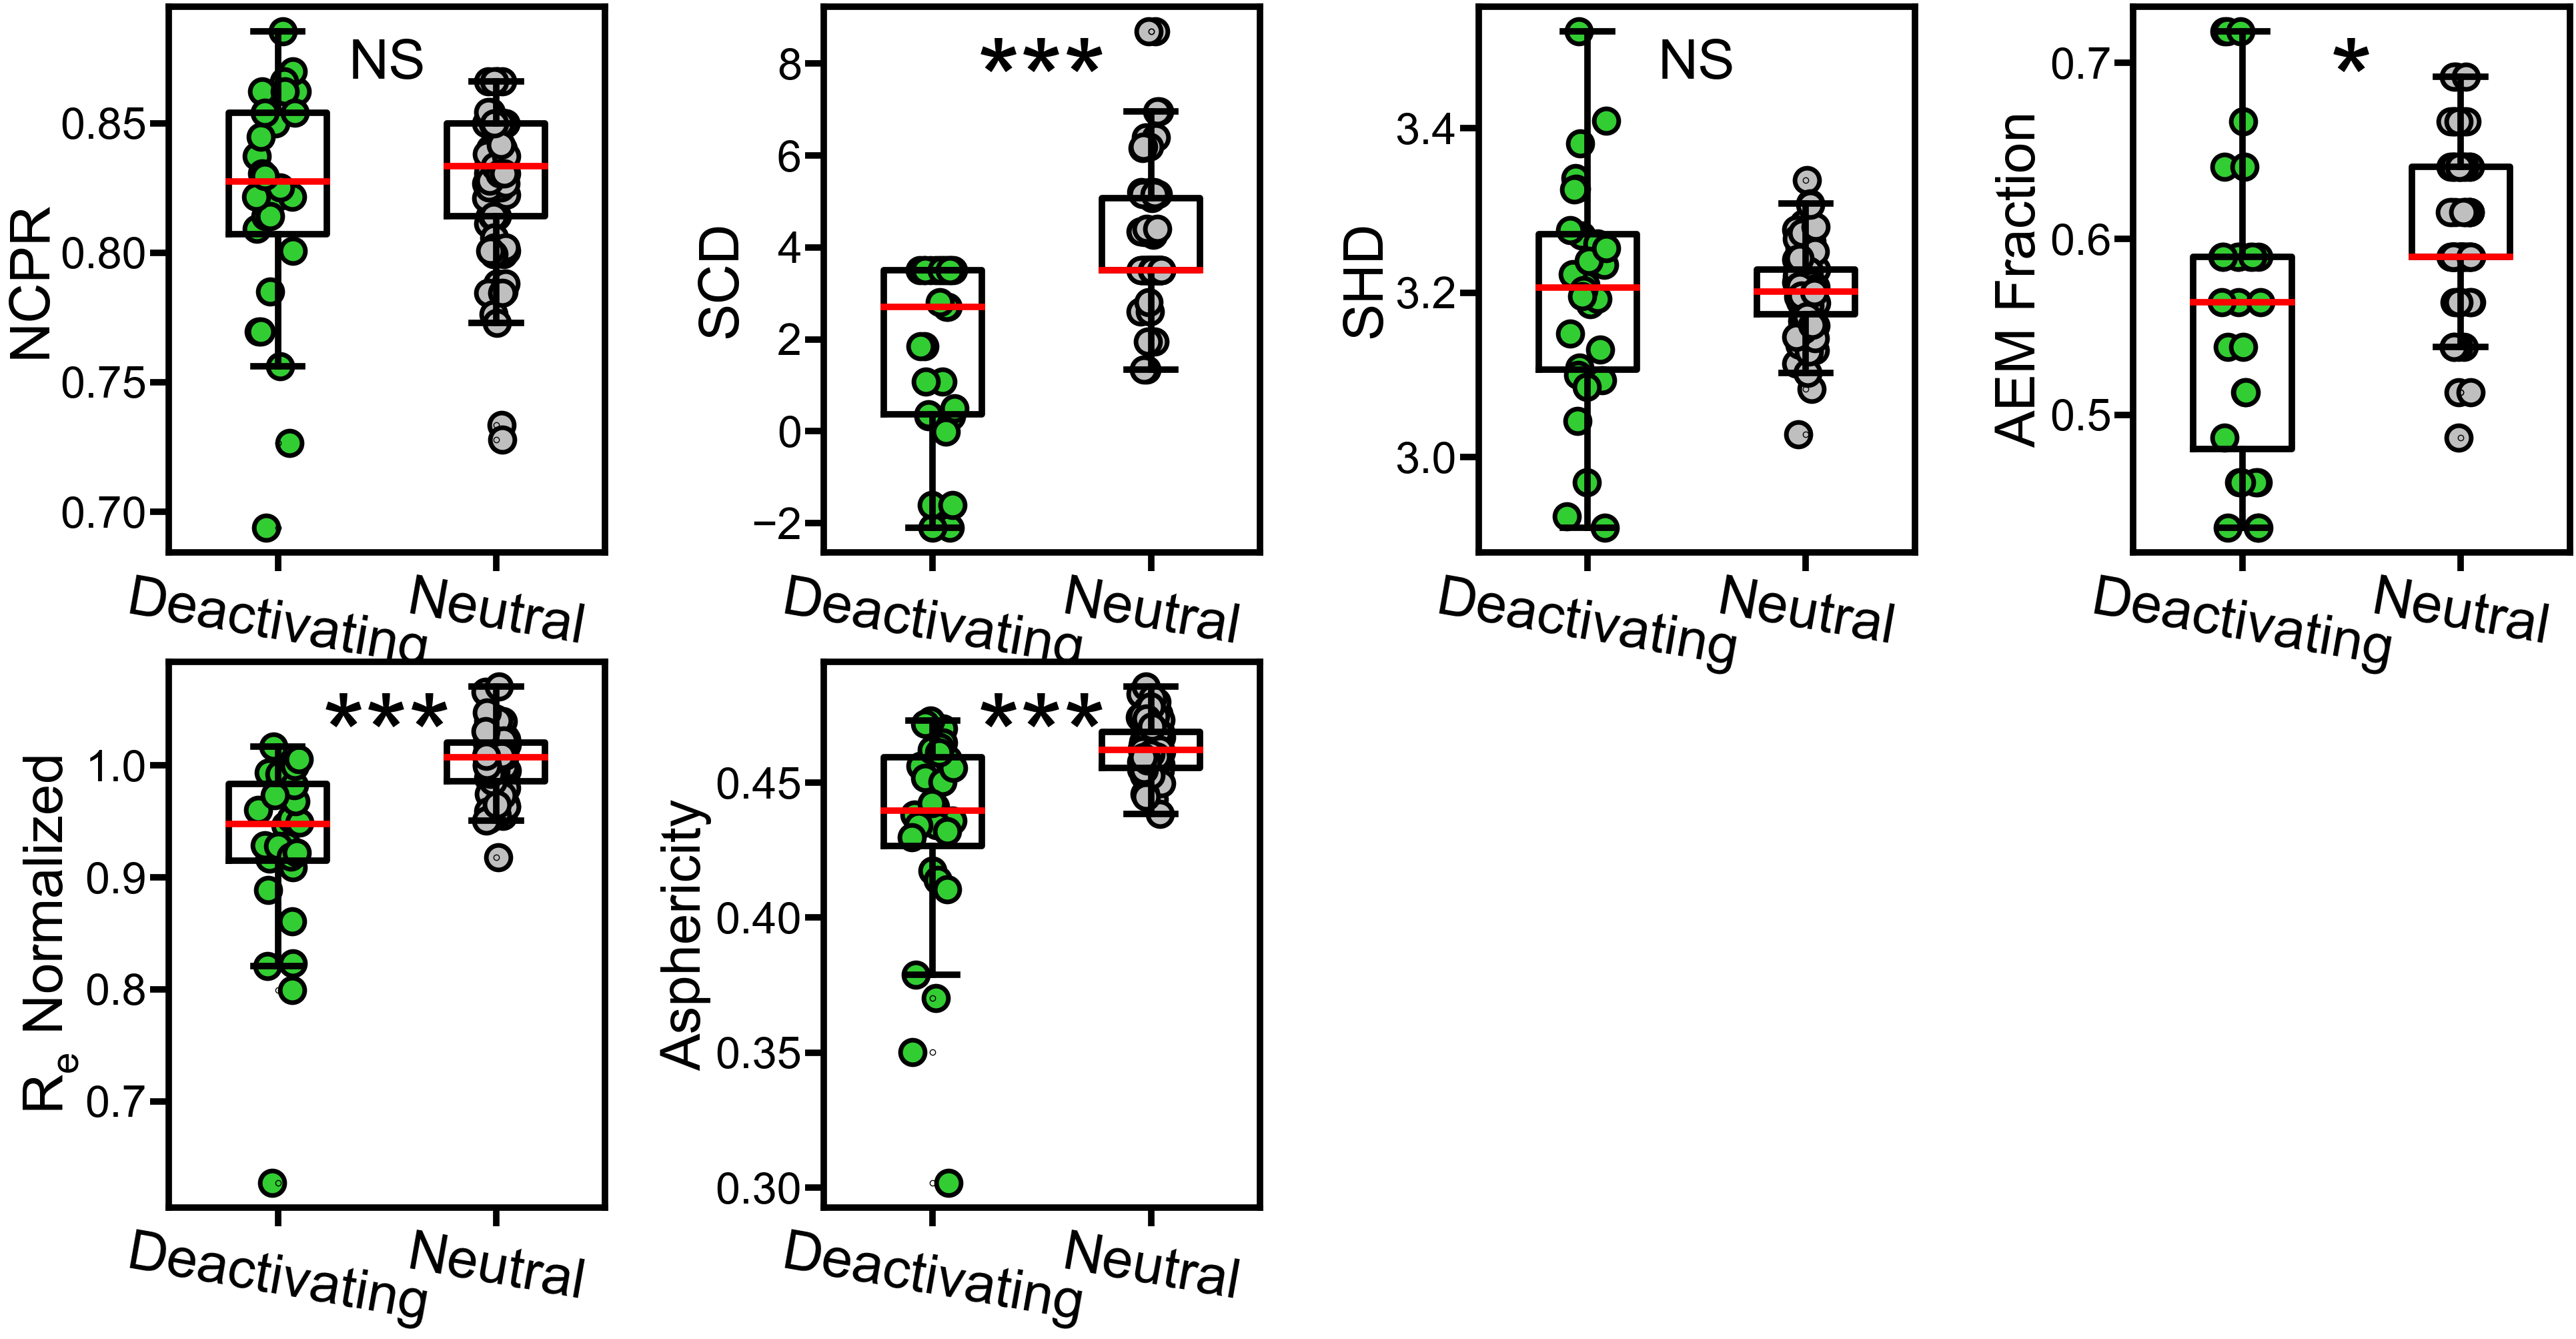

In [138]:
# List of features to plot
# List of features to plot
features = ['NCPR', 'SCD', 'SHD', 'AEM Fraction', '$R_{e}$ Normalized', 'Asphericity']

# Determine the number of rows needed for 4 plots per row
n_rows = 2  # Ensures there are enough rows for all features

# Create a figure with subplots - one for each feature, 4 per row
fig, axs = plt.subplots(n_rows, 4, figsize=(40, 20))
# Function to add jitter
def add_jitter(values, jitter_strength=0.1):
    return values + np.random.uniform(-jitter_strength, jitter_strength, size=len(values))
# Flatten the axs array for easier iteration if it's 2D (necessary when n_rows > 1)
axs = axs.ravel()

# Loop through each feature and create a subplot
for i, feature in enumerate(features):
    # Filter the DataFrame for rows where 'CITED2' is True
    filtered_df = combined_df[combined_df['CITED2']]
    
    # Get values for the current feature based on the 'status' condition
    deactivating_values = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    neutral_values = filtered_df[filtered_df['status'] == 'neutral'][feature]
    
    # Create boxplots on the current axis
    ax = axs[i]
    boxplots = ax.boxplot([deactivating_values, neutral_values], patch_artist=False,widths=0.45)
    
    # Setting the linewidth for the boxplot components
    for element in ['boxes', 'whiskers', 'caps']:
        plt.setp(boxplots[element], linewidth=7, color='black')
    
    # Set the median line color to red
    plt.setp(boxplots['medians'], linewidth=7, color='red')
        
    # Add scatter plot with fixed x positions for each category
    x_deactivating = [1] * len(deactivating_values)
    x_neutral = [2] * len(neutral_values)
     # Add scatter plot with jittered x positions for each category
    x_deactivating = add_jitter(np.ones(len(deactivating_values)), jitter_strength=0.1)
    x_neutral = add_jitter(2 * np.ones(len(neutral_values)), jitter_strength=0.05)
    ax.scatter(x_deactivating, deactivating_values, color='LimeGreen', s=700, edgecolor='black', linewidths=5)
    ax.scatter(x_neutral, neutral_values, color='#BFBFBF', s=700, edgecolor='black', linewidths=5)
    
    # Add significance level as text inside the subplot using normalized coordinates
    significance_asterisk = mann_whitney_results_df.loc[feature, 'asterisk']
    if significance_asterisk == 'NS':
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes, 
                horizontalalignment='center', verticalalignment='top', fontsize=60, color='black')
    else:
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes, 
                horizontalalignment='center', verticalalignment='top', fontsize=120, color='black')

    # Setting labels for axes
    ax.set_ylabel(feature, fontsize=60)
    
    # Explicitly set the x-tick labels for each subplot
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Deactivating', 'Neutral'], fontsize=60,rotation=-10)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)  # Hide unused subplot

# Adjust layout to prevent overlap
#plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.5, hspace=0.2)

# Save the combined figure as an SVG file
plt.savefig("FIGURE_2D+2F.svg", format='svg')
# Show the plot
plt.show()


In [130]:
filtered_df

,Index,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,...,kappa,hy_KD,hy_clust,aro_clust,AEM clustering,SCD,SHD,Aromatic Fraction,Negative Charge Fraction,AEM Fraction
4,4.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGDDEFDFMDD,STQN>D,"T220D,S230D,Q250D,N251D,T257D",4934.729353,580.260971,4662.342770,4519.208720,3848.559508,5150.358116,...,0.256003,4.271795,0.129051,0.082757,0.037519,8.699679,3.114148,0.102564,0.410256,0.666667
5,5.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGQNEFDFMDD,ST>D,"T220D,S230D,T257D",4929.553911,688.559113,4259.084605,4276.234562,4246.226448,5031.713249,...,0.231149,4.271795,0.129051,0.082757,0.054274,6.398789,3.136979,0.102564,0.358974,0.615385
6,6.0,DDFIDEEVLMDLVIEMGLDRIKELPELWLGQNEFDFMTD,ST>Dmut0to20,"T220D,S230D",4920.596376,521.396849,4672.160467,5012.269467,3673.177490,5089.802833,...,0.219307,4.343590,0.129051,0.082757,0.048972,5.207369,3.161443,0.102564,0.333333,0.615385
10,12.0,EDFIDEEVLMELVIEMGLDRIKELPELWLGEEEFDFMED,STQN>E,"T220E,S230E,Q250E,N251E,T257E",5522.323440,1172.910957,5336.792073,4387.979038,4822.957103,4934.043489,...,0.256003,4.271795,0.129051,0.082757,0.037519,8.699679,3.156971,0.102564,0.410256,0.666667
11,13.0,EDFIDEEVLMELVIEMGLDRIKELPELWLGQNEFDFMED,ST>E,"T220E,S230E,T257E",4987.516255,988.613564,5202.254986,4066.235341,3440.023242,5346.668006,...,0.231149,4.271795,0.129051,0.082757,0.054274,6.398789,3.160419,0.102564,0.358974,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,517.0,TDYIDEEVLMSLVIEMGLDRIKELPELYLGQNEYDYMTD,WF>Y,"F222Y,W247Y,F253Y,F255Y",3726.761825,629.997494,3715.148378,3530.774170,3060.171764,3106.079531,...,0.223453,4.158974,0.129051,0.082757,0.056260,3.498430,3.161295,0.102564,0.282051,0.589744
470,518.0,TEFIEEEVLMSLVIEMGLERIKELPELWLGQNEFDFMTD,ED>Emut0to20,"D221E,D224E,D238E",3144.825771,686.883901,3680.793448,2728.489682,2951.250927,2479.166620,...,0.223453,4.484615,0.129051,0.082757,0.056260,3.498430,3.239080,0.102564,0.282051,0.589744
471,519.0,TEFIEEEVLMSLVIEMGLERIKELPELWLGQNEFEFMTE,ED>E,"D221E,D224E,D238E,D254E,D258E",3208.629716,305.383594,2986.304531,2673.700940,2995.332506,3234.454492,...,0.223453,4.484615,0.129051,0.082757,0.056260,3.498430,3.254511,0.102564,0.282051,0.589744
472,520.0,TKFIKKKVLMSLVIKMGLKRIKELPELWLGQNEFDFMTD,ED>Kmut0to20,"D221K,D224K,E225K,E226K,E234K,D238K",2546.054013,726.371036,3289.399753,2127.052673,2127.811956,2001.830976,...,0.400091,4.423077,0.129051,0.082757,0.095530,-1.614512,3.276317,0.102564,0.128205,0.435897


In [131]:
####KS stat test###
import scipy.stats as stats

# List of columns to perform t-tests on
features = ['$R_{e}$ Normalized', 'Rg', 'Re', 'Asphericity', 'NCPR', 'FCR', 'kappa',
            'hy_KD', 'hy_clust', 'aro_clust', 'AEM clustering', 'SCD', 'SHD','Aromatic Fraction',
       'Negative Charge Fraction', 'AEM Fraction']

# Initialize a dictionary to hold the KS test results
ks_test_results = {}

def is_significant(p_val):
    if p_val < 0.0001:
        return '***'  # Triple asterisk for p < 0.0001
    elif p_val < 0.001:
        return '**'   # Double asterisk for p < 0.001
    elif p_val < 0.01:
        return '*'    # Single asterisk for p < 0.01
    else:
        return 'NS'  # No annotation for p >= 0.01

for feature in features:
    # Split the data into two groups based on the 'status' column
    group1 = filtered_df[filtered_df['status'] == 'neutral'][feature]
    group2 = filtered_df[filtered_df['status'] == 'deactivating'][feature]

    # Perform KS test
    ks_stat, p_value = stats.ks_2samp(group1, group2)

    # Store the results including the asterisk annotation
    ks_test_results[feature] = {'KS-statistic': ks_stat, 'p-value': p_value, 'asterisk': is_significant(p_value)}

# Convert results dictionary to DataFrame for nicer display
ks_test_results_df = pd.DataFrame(ks_test_results).transpose()

print(ks_test_results_df)


                         KS-statistic   p-value asterisk
$R_{e}$ Normalized           0.545455  0.000004      ***
Rg                           0.574675  0.000001      ***
Re                           0.545455  0.000004      ***
Asphericity                  0.558442  0.000002      ***
NCPR                         0.266234  0.090212       NS
FCR                          0.162338  0.593924       NS
kappa                        0.269481  0.083649       NS
hy_KD                        0.237013  0.169561       NS
hy_clust                     0.279221  0.066514       NS
aro_clust                    0.116883  0.910357       NS
AEM clustering                0.37987  0.003737        *
SCD                          0.480519  0.000079      ***
SHD                          0.246753  0.138522       NS
Aromatic Fraction            0.214286    0.2627       NS
Negative Charge Fraction     0.344156  0.011555       NS
AEM Fraction                 0.366883  0.005713        *


In [132]:
# Ensure 'Feature' is explicitly a column in each DataFrame
mann_whitney_results_df = mann_whitney_results_df.reset_index().rename(columns={'index': 'Feature'})
t_test_results_df = t_test_results_df.reset_index().rename(columns={'index': 'Feature'})
ks_test_results_df = ks_test_results_df.reset_index().rename(columns={'index': 'Feature'})

# Merge the DataFrames on the 'Feature' column
combined_results_df = mann_whitney_results_df.merge(
    t_test_results_df, on='Feature', how='outer', suffixes=('_mann_whitney', '_t_test')
).merge(
    ks_test_results_df, on='Feature', how='outer'
)
combined_results_df

,Feature,U-statistic,p-value (scientific),asterisk_mann_whitney,t-statistic,p-value_x,asterisk_t_test,KS-statistic,p-value_y,asterisk
0,$R_{e}$ Normalized,1865.0,1.20e-08,***,4.732889,0.000052,***,0.545455,0.000004,***
1,Rg,1867.0,1.11e-08,***,5.418443,0.000007,***,0.574675,0.000001,***
2,Re,1865.0,1.20e-08,***,4.732889,0.000052,***,0.545455,0.000004,***
3,Asphericity,1726.0,2.71e-06,***,3.996531,0.000419,**,0.558442,0.000002,***
4,NCPR,1079.0,9.97e-01,NS,0.63803,0.527644,NS,0.266234,0.090212,NS
5,FCR,1269.5,1.20e-01,NS,1.239903,0.224089,NS,0.162338,0.593924,NS
6,kappa,903.5,1.73e-01,NS,-2.632514,0.009785,*,0.269481,0.083649,NS
7,hy_KD,1213.0,3.30e-01,NS,0.679832,0.502122,NS,0.237013,0.169561,NS
8,hy_clust,675.0,1.30e-03,*,-2.78411,0.00953,*,0.279221,0.066514,NS
9,aro_clust,968.5,3.46e-01,NS,-0.037564,0.970206,NS,0.116883,0.910357,NS


In [133]:
combined_results_df.to_csv('CITED2_PREDICTION_STATS.csv')


In [120]:
pwd

'/Users/eflores500/Documents/STALLER_MANUSCRIPT/GITHUB/FIGURE_2C-2F'